# New Scoring system

## Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#font = {'family' : 'helvetica',  # need to download helvetica
#        'size'   : 12}

font = {'family' : 'serif',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
cd 2017/

/Users/daviddeepwell/Documents/Hockey/Hockey Pool/Playoffs/2017


## Define Functions

In [4]:
def make_plot(data, save=False, text=True, legend=True):
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)
    if not hasattr(data, 'name'):
        data.name = 'Winners'
    name_str = data.name
    name = name_str.split(" - ")[-1]
    #if labels.dtype == np.array([object()]).dtype:
    #    add_asterix = False
    #else:
    #    add_asterix = True
    #winner = False

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    #plt.rc('text', usetex=false)
    #plt.rc('font', family='serif')
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = data[label][-1] 
        for ind in range(len(widths)-1):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if text:
                    ax.text(x, y, "%d" % (w), ha='center',va='center')
                else:
                    ax.text(x, y, "%.2f" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-2:
                xr = bl[0] + patch.get_width() + 2
                xl = data[label][-1] - 1
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    #if add_asterix:
                    #    if find_winner(label) == name:
                    #        ax.text(xr, y, "%d*" % (total), ha='center',va='center')
                    #        winner = True
                    #    else:
                    #        ax.text(xr, y, "%d" % (total), ha='center',va='center')
                    #else:
                    #    ax.text(xr, y, "%d" % (total), ha='center',va='center')
                    ax.text(xr, y, "%d" % (total), ha='center',va='center')
                    ax.text(xl, y, "%d" % (data[label][-1]), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    #ax.set_xlabel('Points')
    plt.title(data.name)
    ax.set_xlim([data.loc['SC'].min()-2, data.sum().max()+1])

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        # Shrink current axis by 25%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

        # remove unused elements of a_bar
        a_bar2 = list(filter(lambda a: a != 0, a_bar))
    
        # Put a legend to the right of the current axis
        #if winner:
        #    plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5),title='* Winner')
        #else:
        #    plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
        plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
    
    # save figure
    if save:
        os.chdir('Figures')
        filename = data.name
        form = 'pdf'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
        os.chdir('..')
    
    # display plot inline
    plt.show();

In [4]:
def read_round(year, rnd):
    fname = str(year)+' Friendly Playoff Pool Round '+str(rnd)+'.csv'
    if os.path.isfile(fname):
        fdata = pd.read_csv(fname, sep=',')
        header = fdata.columns.values
        if rnd == 1:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','SC','R']
        elif rnd == 2:
            header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4']
        elif rnd == 3:
            header[2:] = ['T1','G1','T2','G2']
        elif rnd == 4:
            header[2:] = ['T1','G1']
        fdata.columns = header
        # Remove the string 'Games' in games columns
        max_ind = 2**(4-rnd)+1
        for ind in ['G'+str(x) for x in range(1,max_ind)]:
            if not fdata[ind].values[0] == '- Games':
                fdata[ind] = fdata[ind].map(lambda x: x.rstrip(' Games')).astype(int)
            else:
                if rnd == 1:
                    fdata.iloc[0].values[3:-2:2] = '0 Games'
                else:
                    fdata.iloc[0].values[3::2] = '0 Games'
                fdata[ind] = fdata[ind].map(lambda x: x.rstrip(' Games')).astype(int)
    else:
        fdata = '-'
    return fdata

In [5]:
def get_round_points(year, rnd):
    df = read_round(year, rnd)
    if not isinstance(df, str):
        N_people = df.shape[0]-1
        pts = [0]*N_people
        for ind in range(1,N_people+1):
            if rnd == 1:
                pts[ind-1] = np.where(df.iloc[0].values[2:-2:2] == df.iloc[ind].values[2:-2:2], 
                    np.abs(df.iloc[0].values[3:-1:2]  - df.iloc[ind].values[3:-1:2]),
                    16 -   df.iloc[0].values[3:-1:2]  - df.iloc[ind].values[3:-1:2]).sum()
            else:
                pts[ind-1] = np.where(df.iloc[0].values[3::2] == 0,0,
                    np.where(df.iloc[0].values[2::2] == df.iloc[ind].values[2::2], 
                    np.abs(df.iloc[0].values[3::2]  - df.iloc[ind].values[3::2]),
                    16 -   df.iloc[0].values[3::2]  - df.iloc[ind].values[3::2])).sum()
        ser = pd.Series(pts, index=df['Name:'].values[1:])
    else:
        ser = '-'
    return ser

## Work

In [6]:
r1 = get_round_points(2017, 1)
r2 = get_round_points(2017, 2)
r3 = get_round_points(2017, 3)
r4 = get_round_points(2017, 4)

In [8]:
r1names = r1.index.values
if not isinstance(r2, str):
    r2names = r2.index.values
else:
    r2names = '-'
if not isinstance(r3, str):
    r3names = r3.index.values
else:
    r3names = '-'
if not isinstance(r4, str):
    r4names = r4.index.values
else:
    r4names = '-'

In [9]:
# compare names in different lists
all_names = r1names
#l3 = [x for x in r2names if x not in all_names]

In [10]:
pts1 = [0]*all_names.size
pts2 = [0]*all_names.size
pts3 = [0]*all_names.size
pts4 = [0]*all_names.size
#SC = [0]*all_names.size
ind = 0
for name in all_names:
    if name in r1names:
        pts1[ind] = r1[name]
    else:
        pts1[ind] = np.NaN
    if name in r2names:
        pts2[ind] = r2[name]
    else:
        pts2[ind] = np.NaN
    if name in r3names:
        pts3[ind] = r3[name]
    else:
        pts3[ind] = np.NaN
    if name in r4names:
        pts4[ind] = r4[name]
    else:
        pts4[ind] = np.NaN
    #if name in r1names:
    #    SC[ind] = np.NaN
    #else:
    #    pts4[ind] = np.NaN
    ind = ind+1

In [11]:
# get peoples SC picks
df = read_round(2017, 1)
SCpicks = df.loc[1:,['SC','R']].set_index(df['Name:'].values[1:])

In [12]:
# Find winners of each round
winners = [np.array([np.NaN],dtype=object)]*4
for rnd in range(5):
    df = read_round(2017, rnd)
    if not isinstance(df, str):
        if rnd == 1:
            winners[rnd-1] = df.iloc[0][2:-2:2].values
        else:
            winners[rnd-1] = df.iloc[0][2::2].values

In [13]:
# Get SC points
N_SC = len(SCpicks.index)
SCpts = np.array([0]*N_SC)
for nn in range(N_SC):
    SCtrack = np.array([0]*8)
    for rnd in range(4):
        for ind in range(2):
            if rnd < 3:
                SCtrack[ind+rnd*2] = (SCpicks.iloc[nn].values[ind] in winners[rnd])
            elif ind == 0: # In 4th round only need to check SC winner
                    SCtrack[ind+rnd*2] = SCpicks.iloc[nn].values[ind] == winners[3]
    SCpts[nn] = SCtrack.sum()

In [14]:
all_score = np.vstack((pts1,pts2,pts3,pts4,-SCpts))
df = pd.DataFrame(all_score, index=['R1', 'R2', 'R3', 'R4', 'SC'])
df.columns = all_names

In [15]:
df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=False).index, axis=1)
df_sorted.name = 'Points - '+str(2017)

In [16]:
df_sorted

,Alita,Kyle,Kollin,Ron,Michael,Andre,Anthony,Jackson,Josh,Romulus,David,Jeremy,Brian,Matt
R1,28.0,21.0,17.0,23.0,22.0,23.0,22.0,20.0,18.0,14.0,21.0,19.0,15.0,24.0
R2,14.0,10.0,12.0,5.0,8.0,8.0,9.0,4.0,5.0,12.0,0.0,8.0,4.0,NaN
R3,2.0,6.0,6.0,2.0,7.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,NaN
R4,1.0,4.0,4.0,6.0,0.0,1.0,1.0,5.0,4.0,1.0,3.0,NaN,4.0,NaN
SC,-1.0,-1.0,-3.0,-2.0,-4.0,-1.0,-1.0,-2.0,-2.0,-4.0,-1.0,-4.0,0.0,-2.0


In [17]:
cols = df_sorted.columns.tolist()
new_cols = [cols[-1], cols[-3]] + cols[:-3] + [cols[-2]] # move Matt and Jeremy
df_reorg = df_sorted[new_cols]
df_reorg.name = 'Points - 2017'

In [18]:
df_reorg

,Matt,Jeremy,Alita,Kyle,Kollin,Ron,Michael,Andre,Anthony,Jackson,Josh,Romulus,David,Brian
R1,24.0,19.0,28.0,21.0,17.0,23.0,22.0,23.0,22.0,20.0,18.0,14.0,21.0,15.0
R2,NaN,8.0,14.0,10.0,12.0,5.0,8.0,8.0,9.0,4.0,5.0,12.0,0.0,4.0
R3,NaN,0.0,2.0,6.0,6.0,2.0,7.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0
R4,NaN,NaN,1.0,4.0,4.0,6.0,0.0,1.0,1.0,5.0,4.0,1.0,3.0,4.0
SC,-2.0,-4.0,-1.0,-1.0,-3.0,-2.0,-4.0,-1.0,-1.0,-2.0,-2.0,-4.0,-1.0,0.0


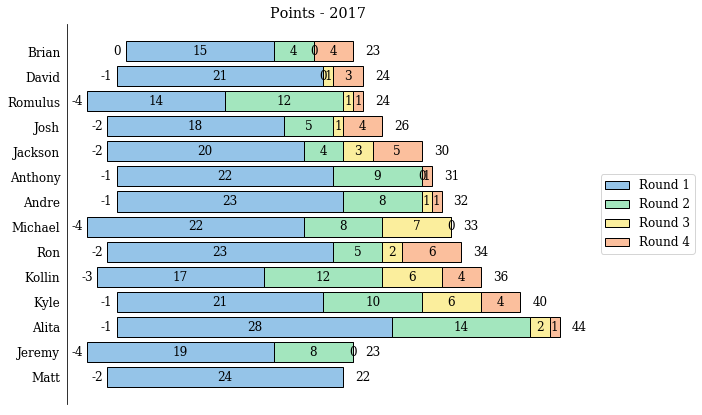

In [19]:
make_plot(df_reorg)

## Get Stanley Cup points

## Define Functions

In [7]:
get_round_points(2017, 1)

Alita      28
Andre      23
Anthony    22
Brian      15
David      21
Jackson    20
Jeremy     19
Josh       18
Kollin     17
Kyle       21
Matt       24
Michael    22
Romulus    14
Ron        23
dtype: int64

In [38]:
df = read_round(2017, 2)

In [39]:
df

,Timestamp,Name:,T1,G1,T2,G2,T3,G3,T4,G4
0,2017/04/24 3:34:17 pm GMT-4,Results,Nashville Predators,6,Anaheim Ducks,7,Ottawa Senators,6,Pittsburgh Penguins,7
1,2017/04/24 3:34:17 pm GMT-4,Alita,St. Louis Blues,6,Edmonton Oilers,7,New York Rangers,5,Washington Capitals,6
2,2017/04/24 3:50:27 pm GMT-4,Brian,Nashville Predators,6,Anaheim Ducks,6,Ottawa Senators,7,Pittsburgh Penguins,5
3,2017/04/24 7:07:20 pm GMT-4,Jackson,Nashville Predators,6,Edmonton Oilers,6,Ottawa Senators,6,Pittsburgh Penguins,6
4,2017/04/24 7:45:38 pm GMT-4,Kyle,St. Louis Blues,6,Edmonton Oilers,6,Ottawa Senators,6,Washington Capitals,6
5,2017/04/24 9:42:34 pm GMT-4,Ron,Nashville Predators,6,Edmonton Oilers,7,Ottawa Senators,6,Washington Capitals,6
6,2017/04/25 4:29:06 pm GMT-4,Jeremy,Nashville Predators,5,Edmonton Oilers,6,New York Rangers,6,Pittsburgh Penguins,7
7,2017/04/25 4:55:21 pm GMT-4,David,Nashville Predators,6,Anaheim Ducks,7,Ottawa Senators,6,Pittsburgh Penguins,7
8,2017/04/26 9:25:44 am GMT-4,Josh,Nashville Predators,6,Edmonton Oilers,7,Ottawa Senators,7,Washington Capitals,7
9,2017/04/26 12:48:19 pm GMT-4,Michael,St. Louis Blues,6,Anaheim Ducks,6,Ottawa Senators,6,Washington Capitals,6


In [41]:
df.iloc[0].values[3::2]

array([6, 7, 6, 7], dtype=object)

In [37]:
ind = 1
df.iloc[0].values[2:-2:2] == df.iloc[ind].values[2:-2:2]

array([False, False, False,  True,  True,  True, False, False], dtype=bool)

In [8]:
year = 2017
rnd = 1
fname = str(year)+' Friendly Playoff Pool Round '+str(rnd)+'.csv'    # read file

In [9]:
fdata = pd.read_csv(fname, sep=',')
# make the names of people the index (the row name)
fdata.index = fdata['Name:']
# over write the column headers
header = fdata.columns.values

In [12]:
header[2:] = ['T1','G1','T2','G2','T3','G3','T4','G4','T5','G5','T6','G6','T7','G7','T8','G8','SC','R']

In [13]:
fdata.columns = header